# Линейная регрессия: переобучение и регуляризация

В этом задании мы на примерах увидим, как переобучаются линейные модели, разберем, почему так происходит, и выясним, как диагностировать и контролировать переобучение.

Во всех ячейках, где написан комментарий с инструкциями, нужно написать код, выполняющий эти инструкции. Остальные ячейки с кодом (без комментариев) нужно просто выполнить. Кроме того, в задании требуется отвечать на вопросы; ответы нужно вписывать после выделенного слова "__Ответ:__".

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

## Задание 1

Загрузите датасет с помощью функции __pandas.read_csv__ в переменную __df__. Выведите первые 5 строчек, чтобы убедиться в корректном считывании данных:

In [7]:
df = pd.read_csv('bikes_rent.csv')
df
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными. С номинальныеми признаками тоже можно работать как с вещественными, потому что на них задан порядок. Давайте посмотрим на графиках, как целевой признак зависит от остальных

Постройте графики зависимостей атрибутов от количества поездок. Другими словами вам нужно построить 12 графиков. На каждом должна быть изображена зависимость очередного атрибута от переменной **cnt**.

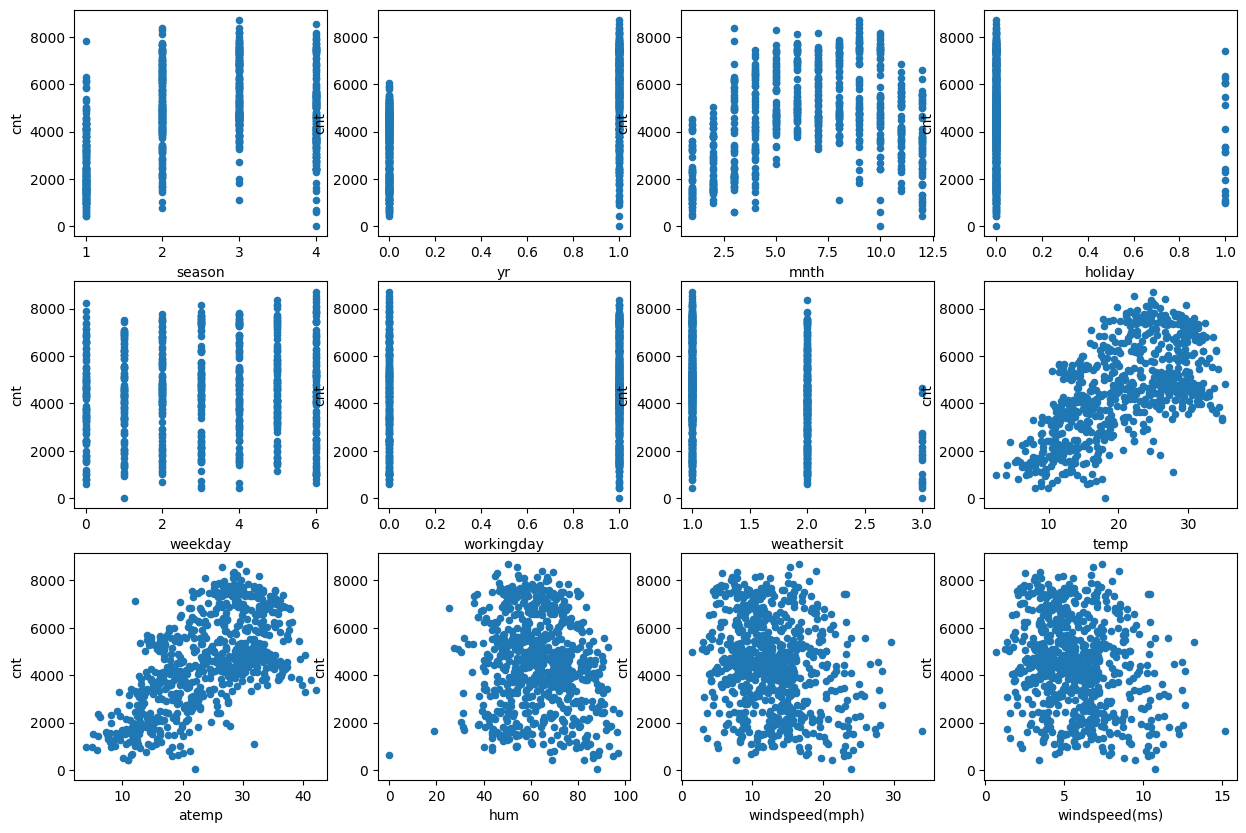

In [8]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])


__Вопросы:__
1. Каков характер зависимости числа прокатов от месяца?
1. Укажите один или два признака, от которых число прокатов скорее всего зависит линейно

In [ ]:
# 1.не линейная зависимость
# 2. yr, temp, atamp

## Задание 2

Давайте более строго оценим уровень линейной зависимости между признаками и целевой переменной. Хорошей мерой линейной зависимости между двумя векторами является корреляция Пирсона. Нам уже приходилось иметь с ней дело раньше. Для ее вычисления в pandas можно использовать методы датафрейма: corr и corrwith.

Посчитайте корреляции всех признаков, кроме последнего, с последним с помощью метода `corrwith`.

In [9]:
a = df[['season', 'yr',	'mnth',	'holiday', 'weekday', 'workingday',	'weathersit','temp', 'atemp','hum','windspeed(mph)','windspeed(ms)']]
print(a.corr())
b = (df.corrwith(df['cnt'], method = 'pearson'))
print(b)



                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.229046 -0.011817 -0.20

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

## Задание 3

Посчитайте попарные корреляции между признаками temp, atemp, hum, windspeed(mph), windspeed(ms) и cnt
с помощью метода corr:

In [10]:
df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


На диагоналях, как и полагается, стоят единицы. Однако в матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Напоследок посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

## Задание 4

Выведите средние признаков

In [11]:
df.mean()


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

Итак, в наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [12]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle



In [13]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]
print(X, y)

[[ 1.354375    0.99863295  1.58866019 ...  0.74372737 -0.21121111
  -0.21121111]
 [-1.34821315 -1.00136893 -1.31026791 ... -1.33538868  1.12681211
   1.12681211]
 [ 1.354375   -1.00136893  1.00887457 ... -0.29551449  0.50349108
   0.50349108]
 ...
 [ 1.354375   -1.00136893  0.71898176 ...  1.55169951 -0.5404777
  -0.5404777 ]
 [-1.34821315  0.99863295 -1.0203751  ... -1.06046036  0.41449871
   0.41449871]
 [-0.44735043 -1.00136893 -0.73048229 ...  1.34385394  0.77643372
   0.77643372]] 703    6606
33     1550
300    3747
456    6041
633    7538
       ... 
71     2417
106    3744
270    3907
435    4911
102    2162
Name: cnt, Length: 731, dtype: int64


Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [14]:
import sklearn.datasets 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import numpy as np

## Задание 5

Создайте объект линейного регрессора, обучите его на всех данных и выведите веса модели (веса хранятся в переменной `coef_` класса регрессора). Можно выводить пары (название признака, вес), воспользовавшись функцией `zip`, встроенной в язык python. Названия признаков хранятся в переменной `df.columns`.


In [15]:
regressor = LinearRegression()
regressor.fit(X, y)
for weight, name in zip(regressor.coef_, df.columns[:-1]):
    print('%s - %s' % (name, weight))

season - 570.8682265577049
yr - 1021.9699617927133
mnth - -141.30396124932304
holiday - -86.75631662475479
weekday - 137.22302240762895
workingday - 56.39163717028827
weathersit - -330.22444879183723
temp - 367.48475596189166
atemp - 585.5457815991487
hum - -145.61572467018243
windspeed(mph) - 12452253201694.951
windspeed(ms) - -12452253201893.412


Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках. Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$$w = (X^TX)^{-1} X^T y$$

Если в $X$ есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

С парой (temp, atemp) чуть менее коррелирующих переменных такого не произошло, однако на практике всегда стоит внимательно следить за коэффициентами при похожих признаках.

Для того, чтобы решить проблему мультиколлинеарности нужно воспользоваться регуляризатором. К оптимизируемому функционалу прибавляют $L_1$ или $L_2$ норму весов, умноженную на коэффициент регуляризации $\alpha$. В первом случае метод называется Lasso, а во втором --- Ridge.

### Задание 6
Давайте попробуем обучить линейные модели с $L_1$ и $L_2$-регуляризацией, а далее сравним их веса. Обучите регрессоры Ridge и Lasso с параметрами по умолчанию и убедитесь, что проблема с весами решилась.

Обучите линейную модель с $L_1$-регуляризацией (класс Lasso) и выведите веса

In [16]:
lasso = Lasso(alpha=0.1)
sc_x = StandardScaler()
sc_y = StandardScaler()
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X, y, test_size=0.3, random_state=0)
X_train_scaled.std(), X_train_scaled.mean()
lasso.fit(X_train_scaled, y_train_scaled)
print(lasso.coef_)


[ 5.24898669e+02  1.01117673e+03 -1.04967464e+02 -1.12676677e+02
  1.26253167e+02  4.24046641e+01 -3.05470995e+02  4.72560262e+02
  5.12543780e+02 -1.56545828e+02 -1.87521261e+02 -3.21143263e-08]


Обучите линейную модель с $L_2$-регуляризацией (класс Ridge) и выведите веса

In [17]:
ridge = Ridge(alpha=0.1)
ridge.fit(X_train_scaled, y_train_scaled)
y_train_pred = ridge.predict(X_train_scaled)
print(ridge.coef_)

[ 525.09910457 1011.07789164 -105.21384068 -112.70455433  126.37713006
   42.48690537 -305.41991808  468.14544779  516.93269463 -156.69725244
  -93.77576011  -93.77576087]


### Задание 7

В отличие от $L_2$-регуляризации, $L_1$ обнуляет веса при некоторых признаках Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

Для каждого значения коэффициента из `alphas` обучите регрессор `Lasso` и запишите веса список `coefs_lasso`, а затем обучите `Ridge` и запишите веса в список`coefs_ridge`. Конвертируйте полученные списки в `np.array`.

In [18]:
import numpy as np
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
for alpha in alphas:
    las = Lasso(alpha=alpha)
    las.fit(X, y)
    coefs_lasso = las.coef_
    rid = Ridge(alpha=alpha)
    rid.fit(X, y)
    coefs_ridge = rid.coef_

my_array_1 = np.array(coefs_lasso)
print(my_array_1)
my_array_2 = np.array(coefs_ridge)
print(my_array_2)

[ 93.3517423  613.05463922   0.          -0.           0.
   0.         -10.41856902   0.         709.13087706  -0.
  -0.          -0.        ]
[ 267.03109023  639.19536755   89.01232285  -62.95890597   81.86490933
   43.62477037 -235.26399722  393.29798599  396.13815546 -130.70987223
  -97.49343362  -97.49343362]


Проанализируйте динамику весов при увеличении параметра регуляризации:

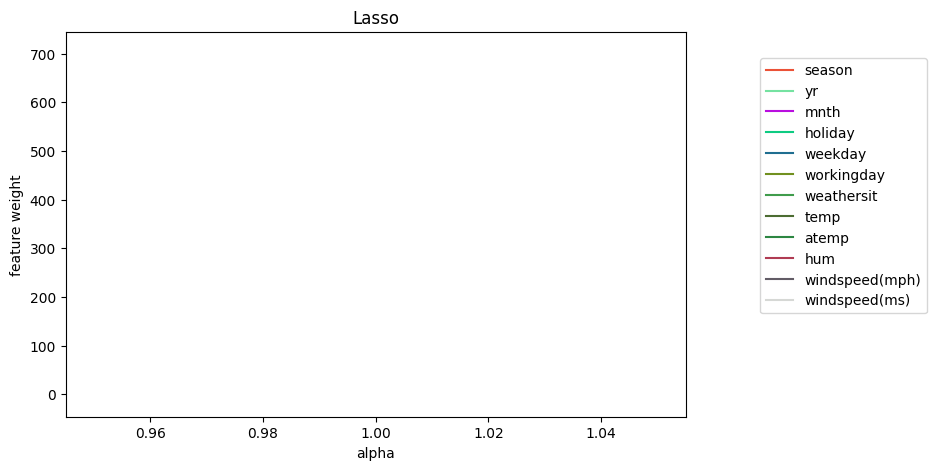

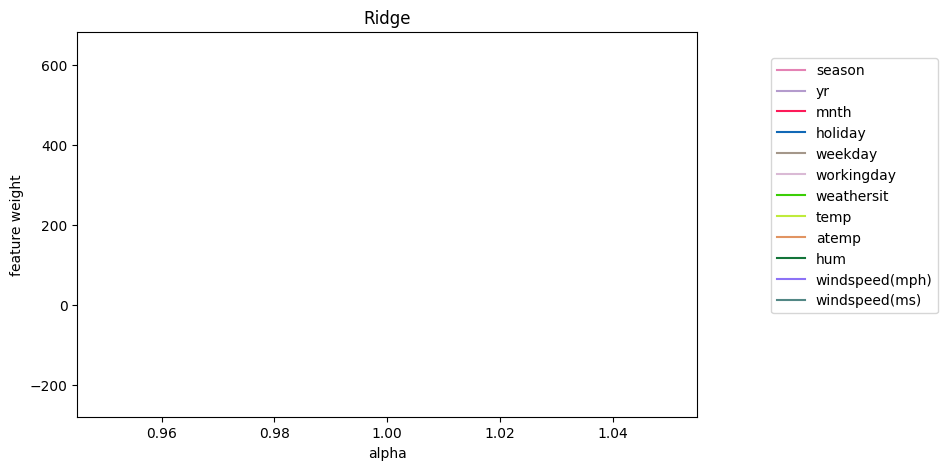

In [29]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Проанализируйте графики и дайте ответы на следующие вопросы.

1. Какой регуляризатор (Ridge или Lasso) агрессивнее уменьшает веса при одном и том же alpha?
1. Что произойдет с весами Lasso, если alpha сделать очень большим? Поясните, почему так происходит.
1. Можно ли утверждать, что `Lasso` исключает один из признаков `windspeed` при любом значении `alpha > 0`? А Ridge? Считается, что регуляризатор исключает признак, если коэффициент при нем меньше $10^{-3}$.
1. Какой из регуляризаторов подойдет для отбора неинформативных признаков?

### Задание 8

Далее будем работать с `Lasso`.

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha.

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть `Mean Square Error`.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать `alpha` по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (это называется holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на $K$ часте, и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

Делать кросс-валидацию для регрессии в sklearn совсем просто: для этого есть специальный регрессор, __LassoCV__, который берет на вход список из alpha и для каждого из них вычисляет MSE на кросс-валидации. После обучения (если оставить параметр cv=3 по умолчанию) регрессор будет содержать переменную __mse\_path\___, матрицу размера len(alpha) x k, k = 3 (число блоков в кросс-валидации), содержащую значения MSE на тесте для соответствующих запусков. Кроме того, в переменной alpha\_ будет храниться выбранное значение параметра регуляризации, а в coef\_, традиционно, обученные веса, соответствующие этому alpha_.

Обратите внимание, что регрессор может менять порядок, в котором он проходит по alphas; для сопоставления с матрицей MSE лучше использовать переменную регрессора alphas_.

Обучите регрессор `LassoCV` на всех параметрах регуляризации из alpha. Постройте график _усредненного_ по строкам `MSE` в зависимости от `alpha` (используйте для этого функцию `create_plot`).

Выведите выбранное `alpha`, а также пары "признак-коэффициент" для обученного вектора коэффициентов.

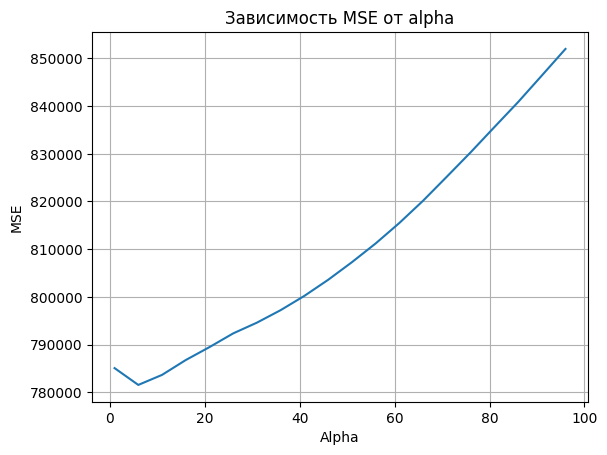

In [152]:
from sklearn.linear_model import LassoCV

def create_plot(las, title, xlabel, ylabel):
    alphas = np.arange(1, 100, 5)
    las = LassoCV(alphas=alphas, cv=3)
    las.fit(X, y)
    avg = np.average(las.mse_path_, axis = 1)
    indexes = np.argsort(las.alphas_)
    plt.plot(alphas, avg[indexes])
    plt.title('Зависимость MSE от alpha')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

create_plot(las, plt.title, plt.xlabel, plt.ylabel)

In [110]:
from sklearn.linear_model import LassoCV
alphas = np.arange(1, 100, 5)
las = LassoCV(alphas=alphas, cv=3)
las.fit(X, y)
avg = np.average(las.mse_path_, axis = 1)
indexes = np.argsort(las.alphas_)
regressor ='Minimum MSE: %s\nAlpha: %s' % (np.min(avg), alphas[indexes[np.argmin(avg)]])
print(regressor)

Minimum MSE: 781531.0908199243
Alpha: 6


Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

### Задание 9

Выведите значения `alpha`, соответствующие минимумам `MSE` на каждом разбиении (то есть по столбцам).
На трех отдельных графиках визуализируйте столбцы `mse_path_`.


Minimum MSE: 733725.7604052243
Alpha: 6
Minimum MSE: 799433.1673691692
Alpha: 1
Minimum MSE: 796979.8955193626
Alpha: 51


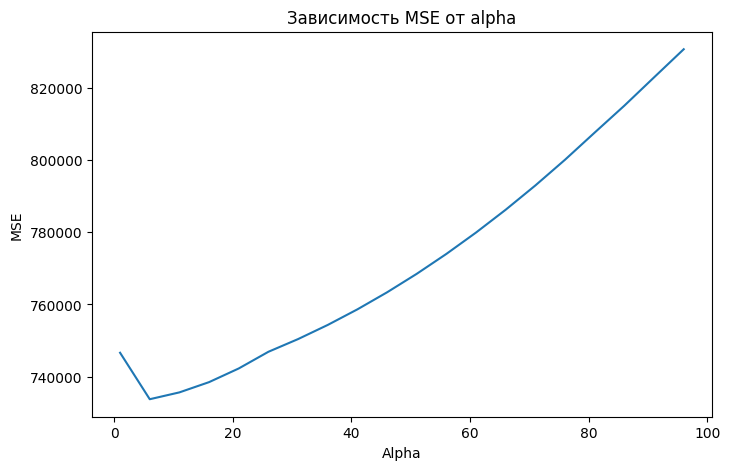

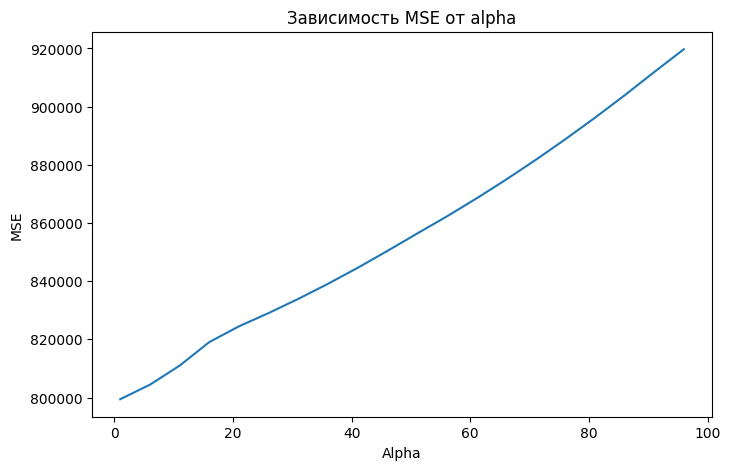

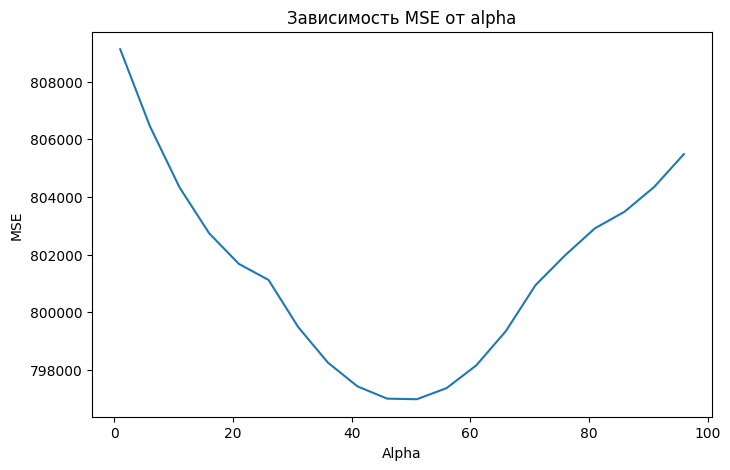

In [116]:

def build_by_column_index(las, index):
    plt.figure(figsize=(8, 5))
    indexes = np.argsort(las.alphas_)
    avg = las.mse_path_[:, index]
    plt.plot(alphas, avg[indexes])
    plt.title('Зависимость MSE от alpha')
    plt.xlabel('Alpha')
    plt.ylabel('MSE')

    print('Minimum MSE: %s\nAlpha: %s' % (np.min(avg), alphas[indexes[np.argmin(avg)]]))
    
build_by_column_index(las, 0)
build_by_column_index(las, 1)
build_by_column_index(las, 2)


На каждом разбиении оптимальное значение `alpha` свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе `alpha` на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Задание 10

Наконец, как принято в анализе данных, давайте проинтерпретируем результат. Ответьте на следующие вопросы.

#### Вопрос 1

В последней обученной модели выберите 4 признака с наибольшими (положительными) коэфициентами (и выпишите их), посмотрите на визуализации зависимостей `cnt` от этих признаков, которые мы рисовали в блоке "Знакомство с данными". Видна ли возрастающая линейная зависимость `cnt` от этих признаков по графикам? Логично ли утверждать (из здравого смысла), что чем больше значение этих признаков, тем больше людей захотят взять велосипеды? 

__Ответ:__

In [11]:
#yr, atemp, season, temp. Да, для этих признаков видна линейная зависимость для cnt от них. Да, логично утвреждать что чем больше значение этих признаков, тем больше людей захотят взять велосипеды.

#### Вопрос 2

Выберите 3 признака с наибольшими по модулю отрицательными коэффициентами (и выпишите их), посмотрите на соответствующие визуализации. Видна ли убывающая линейная зависимость? Логично ли утверждать, что чем больше величина этих признаков, тем меньше людей захотят взять велосипеды?

__Ответ:__

In [12]:
#weathersit, windspeed(mph), hum, mnth. Да, логично утвреждать что чем менше значение этих признаков, тем больше людей захотят взять велосипеды.

#### Вопрос 3

Выпишите признаки с коэффициентами, близкими к нулю (< 1e-3). Как вы думаете, почему модель исключила их из модели (вновь посмотрите на графики)? Верно ли, что они никак не влияют на спрос на велосипеды?

__Ответ:__

In [13]:
#windspeed(ms). Нет, данный признак влияет на спрос на велосипеды, просто он уже был учтен в параметру windspeed(mph) и тепер является избыточным для модели.

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 

Стоит отметить, что с помощью кросс-валидации удобно подбирать лишь небольшое число параметров (1, 2, максимум 3), потому что для каждой допустимой их комбинации нам приходится несколько раз обучать модель. Такой процесс занимает много времени, особенно если нужно обучаться на больших объемах данных.